In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)


In [5]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values


In [6]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)


In [7]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [9]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)


In [10]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [11]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


In [12]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    val_target = []
    val_predict = []

    # Training
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))

    print(f'EPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 282.769	Validation loss: 88.671
EPOCH 2:	Training loss: 137.646	Validation loss: 72.294
EPOCH 3:	Training loss: 71.070	Validation loss: 19.371
EPOCH 4:	Training loss: 24.804	Validation loss: 186.688
EPOCH 5:	Training loss: 92.399	Validation loss: 19.700
EPOCH 6:	Training loss: 17.711	Validation loss: 13.641
EPOCH 7:	Training loss: 19.708	Validation loss: 12.308
EPOCH 8:	Training loss: 38.663	Validation loss: 47.827
EPOCH 9:	Training loss: 17.413	Validation loss: 42.953
EPOCH 10:	Training loss: 25.419	Validation loss: 41.527
EPOCH 11:	Training loss: 27.256	Validation loss: 19.484
EPOCH 12:	Training loss: 9.713	Validation loss: 5.797
EPOCH 13:	Training loss: 14.974	Validation loss: 16.683
EPOCH 14:	Training loss: 12.200	Validation loss: 13.667
EPOCH 15:	Training loss: 14.411	Validation loss: 8.119
EPOCH 16:	Training loss: 10.668	Validation loss: 19.283
EPOCH 17:	Training loss: 12.520	Validation loss: 14.454
EPOCH 18:	Training loss: 15.566	Validation loss: 12.801
E

In [14]:
X_test = X_test.to(device)
y_test = y_test.to(device)


In [15]:
model.eval()
X_test = X_test.to(device)  # Đưa X_test lên cùng thiết bị
y_test = y_test.to(device)  # Đưa y_test lên cùng thiết bị

with torch.no_grad():
    y_hat = model(X_test)  # Dự đoán trên tập test
    test_set_r2 = r_squared(y_test.cpu().numpy(), y_hat.cpu().numpy())  # Tính R2
    print('Evaluation on test set:')
    print(f'R2: {test_set_r2}')


Evaluation on test set:
R2: 0.8765133619308472


TEST MINH HOẠ

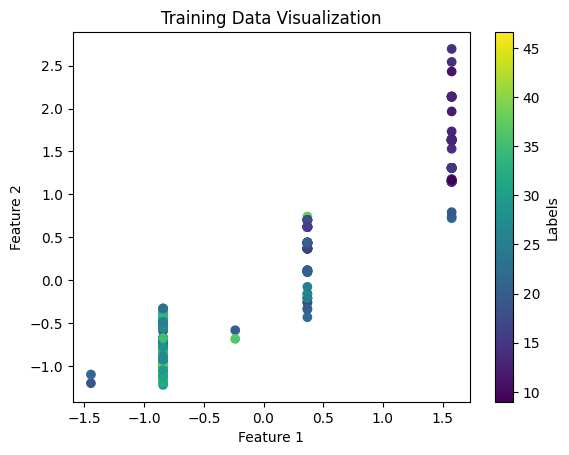

In [16]:
import matplotlib.pyplot as plt

# Giả sử dữ liệu có 2 đặc trưng (chỉ phù hợp với dữ liệu 2D)
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training Data Visualization')
plt.colorbar(label='Labels')
plt.show()


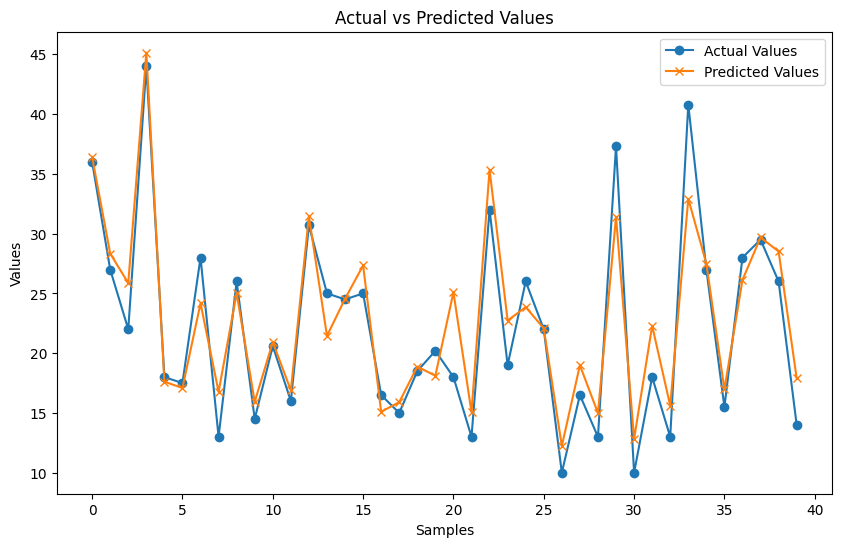

In [17]:
# Chuyển dữ liệu dự đoán và thực tế về dạng NumPy
y_test_np = y_test.cpu().numpy()
y_hat_np = y_hat.cpu().numpy()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label='Actual Values', marker='o')
plt.plot(y_hat_np, label='Predicted Values', marker='x')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


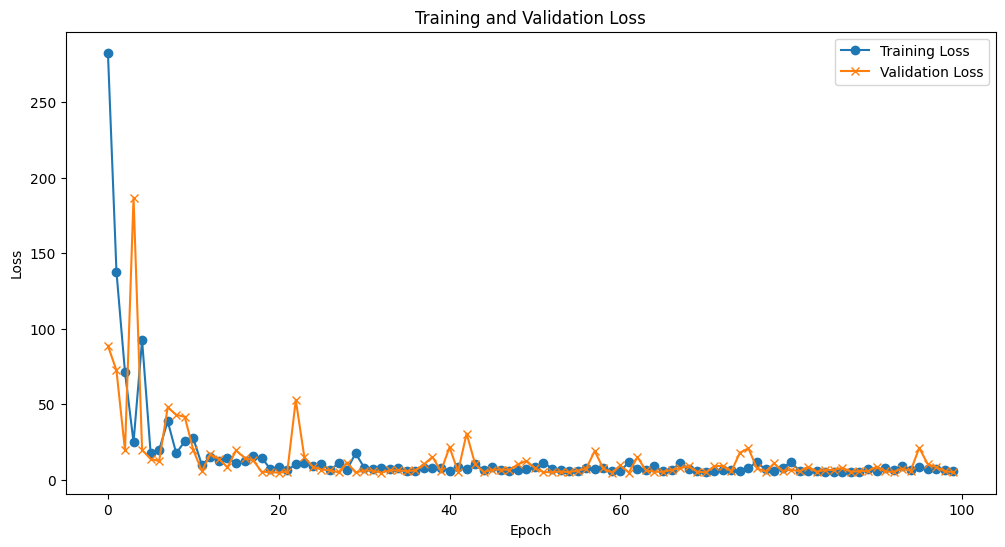

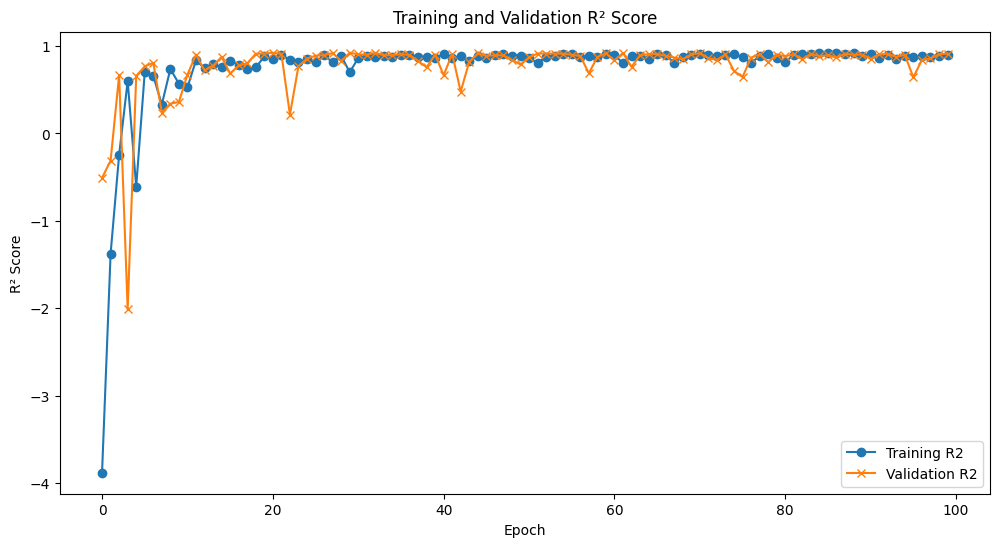

In [19]:
# Vẽ Training Loss và Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Chuyển tensor về CPU và sau đó thành NumPy
train_r2_cpu = [r2.cpu().item() if torch.is_tensor(r2) else r2 for r2 in train_r2]
val_r2_cpu = [r2.cpu().item() if torch.is_tensor(r2) else r2 for r2 in val_r2]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_r2_cpu, label='Training R2', marker='o')
plt.plot(val_r2_cpu, label='Validation R2', marker='x')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Training and Validation R² Score')
plt.legend()
plt.show()
